In [1]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

Resolusi = 256 #500

TRAINING_DIR = "C:/Users/User/Desktop/Tomatoes Diseases Dataset/Dataset Train"
training_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

VALIDATION_DIR = "C:/Users/User/Desktop/Tomatoes Diseases Dataset/Dataset Test"

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(Resolusi,Resolusi),
    shuffle = True,
    class_mode='categorical',
    batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(Resolusi,Resolusi),
    class_mode='categorical',
    shuffle = True,
    batch_size= 32 ) #14)


Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

In [3]:
from kerastuner import HyperModel
from kerastuner import HyperParameters
from tensorflow.keras import optimizers

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(500, 500, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

NUM_CLASSES = 10

INPUT_SHAPE = (500, 500, 3) 

class TuningModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(2048, activation=hp.Choice('dense_activation1',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'
            ))(x)
        x = Dropout(rate=hp.Float(
                        'dropout_1',
                        min_value=0.0,
                        max_value=0.5,
                        default=0.25,
                        step=0.05,
                    ))(x)
        x = Dense(1024, activation=hp.Choice('dense_activation2',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'
            ))(x)
        x = Dense(512, activation=hp.Choice('dense_activation3',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'
            ))(x)
        
        x = Dropout(rate = hp.Float(
                        'dropout_2',
                        min_value=0.0,
                        max_value=0.5,
                        default=0.25,
                        step=0.05,
                    ))(x)
        predictions = Dense(10, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        
        for layer in base_model.layers:
            layer.trainable = False
        
        model.compile(optimizer=optimizers.RMSprop(hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
        )),
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
        
        return model

        
hypermodel = TuningModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [4]:
from kerastuner.tuners import RandomSearch

SEED = 1
MAX_TRIALS = 50
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search'
    #project_name='cifar10'
)

INFO:tensorflow:Reloading Oracle from existing project random_search\untitled_project\oracle.json


In [5]:
# Check tuner
tuner.search_space_summary()

Search space summary
Default search space size: 7
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dense_activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dense_activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dense_activation3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}


In [8]:
# Search
N_EPOCH_SEARCH = 20

tuner.search( train_generator,
    steps_per_epoch = 14,
    epochs = N_EPOCH_SEARCH,
    validation_data = validation_generator,
    validation_steps = 32 ) #14)

Trial 52 Complete [03h 49m 52s]
val_acc: 0.798828125

Best val_acc So Far: 0.828125
Total elapsed time: 03h 44m 52s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

Results summary
Results in random_search\untitled_project
Showing 10 best trials
Objective(name='val_acc', direction='max')
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.05
dropout_2: 0.0
learning_rate: 4.03252709162638e-05
dense_activation1: relu
dense_activation2: relu
dense_activation3: tanh
Score: 0.828125
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.4
dropout_2: 0.05
learning_rate: 0.00015513845419582906
dense_activation1: tanh
dense_activation2: relu
dense_activation3: sigmoid
Score: 0.82470703125
Trial summary
Hyperparameters:
dense_activation: tanh
dropout_1: 0.05
dropout_2: 0.30000000000000004
learning_rate: 0.00016236980265112893
dense_activation1: relu
dense_activation2: tanh
dense_activation3: sigmoid
Score: 0.81787109375
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.1
dropout_2: 0.05
learning_rate: 0.00018328792004345589
dense_activation1: tanh
dense_activation2: sigmoid
dense_activation3: sigmoid
Score: 0.808

In [14]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Save Model
import os 

# Create folder
#os.makedirs('Tubes PCD Model/')
best_model.save('Tugas Besar Program Google Bangkit 2021') 

INFO:tensorflow:Assets written to: Tugas Besar Program Google Bangkit 2021\assets


In [18]:
#To train the top 2 inception blocks, freeze the first 249 layers and unfreeze the rest.

#model = best_model

for layer in model.layers[:249]:
  layer.trainable = False
for layer in model.layers[249:]:
  layer.trainable = True

#Recompile the model for these modifications to take effect
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 32 #14
)

Epoch 1/10
14/14 [==============================] - 524s 37s/step - loss: 0.4344 - acc: 0.8640 - val_loss: 0.4846 - val_acc: 0.8418
Epoch 2/10
14/14 [==============================] - 560s 40s/step - loss: 0.4081 - acc: 0.8828 - val_loss: 0.4597 - val_acc: 0.8574
Epoch 3/10
14/14 [==============================] - 578s 41s/step - loss: 0.4080 - acc: 0.8711 - val_loss: 0.4538 - val_acc: 0.8535
Epoch 4/10
14/14 [==============================] - 571s 41s/step - loss: 0.4074 - acc: 0.8767 - val_loss: 0.4245 - val_acc: 0.8662
Epoch 5/10
14/14 [==============================] - 489s 35s/step - loss: 0.4093 - acc: 0.8683 - val_loss: 0.4109 - val_acc: 0.8770
Epoch 6/10
14/14 [==============================] - 488s 35s/step - loss: 0.3644 - acc: 0.8917 - val_loss: 0.4096 - val_acc: 0.8604
Epoch 7/10
14/14 [==============================] - 488s 35s/step - loss: 0.3634 - acc: 0.8878 - val_loss: 0.3975 - val_acc: 0.8740
Epoch 8/10
14/14 [==============================] - 10489s 749s/step - loss:

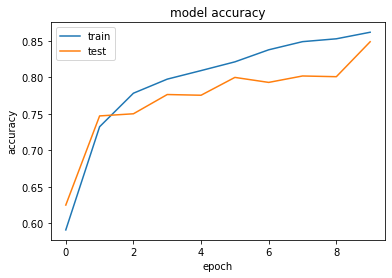

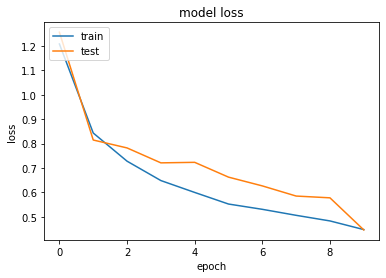

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy

plt.plot(history.history['acc'])2edzw
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')a
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

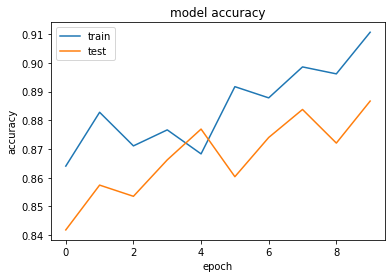

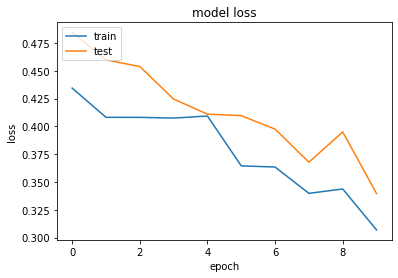

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [22]:
model.save( "Best_Model_Tuning_Hyperparameter_Training_Layer_Atas.h5" )

In [28]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                       , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

test_data = tf_data_generator( validation_generator , ( 256 , 256 , 3))
#train_data = tf_data_generator(train_generator, input_shape)
#test_data = tf_data_generator(test_generator, input_shape)
#val_data = tf_data_generator(val_generator, input_shape)

loss, acc = model.evaluate(test_data, steps=len( validation_generator ) , verbose= 1 )

print('Accuracy on Dataset Test: {:.4f} \nLoss on Dataset Test: {:.4f}'.format(acc,loss),'\n')

100/100 [==============================] - 480s 5s/step - loss: 0.3516 - acc: 0.8881
Accuracy on Dataset Test: 0.8881 
Loss on Dataset Test: 0.3516 



In [29]:
train_data = tf_data_generator( train_generator , ( 256 , 256 , 3 ))

loss , acc = model.evaluate( train_data , steps = len( train_generator ) , verbose = 1 )

print("Accuracy on Dataset Train : {:.4f} \nLoss on Dataset Train : {:.4f}".format( acc , loss ), '\n')

101/101 [==============================] - 2175s 22s/step - loss: 0.3095 - acc: 0.9051
Accuracy on Dataset Train : 0.9051 
Loss on Dataset Train : 0.3095 



Prediction : False [0.32370368 0.02124118 0.00256768 0.00334705 0.03252761 0.02028306
 0.38469616 0.01175182 0.00092234 0.19895956]


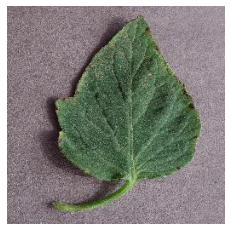

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


path = "C:/Users/User/Desktop/Tomatoes Diseases Dataset Test Image.jpg"
img = image.load_img(path, target_size=( 256, 256 ))

x = image.img_to_array(img)
    
x = np.expand_dims(x, axis = 0)/255
classes = model.predict(x)

#show image
img=mpimg.imread(path)
plt.imshow(img)
plt.grid(False)
plt.axis('off')

#print("Prediction :", np.argmax(classes[0])==0, max([classes[0]]))

In [34]:
classes

array([[0.32370368, 0.02124118, 0.00256768, 0.00334705, 0.03252761,
        0.02028306, 0.38469616, 0.01175182, 0.00092234, 0.19895956]],
      dtype=float32)

In [36]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                       , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

test_data = tf_data_generator( validation_generator , ( 256 , 256 , 3))
#train_data = tf_data_generator(train_generator, input_shape)
#test_data = tf_data_generator(test_generator, input_shape)
#val_data = tf_data_generator(val_generator, input_shape)

loss, acc = model.evaluate(test_data, steps=len( validation_generator ) , verbose= 1 )



print('Accuracy on Dataset Test: {:.4f} \nLoss on Dataset Test: {:.4f}'.format(acc,loss),'\n')



100/100 [==============================] - 480s 5s/step - loss: 0.3516 - acc: 0.9257
Accuracy on Dataset Test : 0.9257 
Loss on Dataset Test : 0.3516
